In [406]:
from collections import Counter
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import copy

In [407]:
def map_path(game, path):
    '''
    Print the chosen path on the game board.
    '''
    l = [x[:] for x in game.lake]
    for x, y, a in path:
        l[x][y] = FrozenLake.actions[a]
    
    return '\n'.join(('|' + ''.join(row) + '|') for row in l).replace('F', ' ').replace('H', 'X')

In [408]:
class FrozenLake(object):
    '''
    A frozen lake game! It's a lake that's frozen, but it's got some holes that you should
    avoid. Or, maybe it's a desert with patches of quicksand. Either way, you have to get from 
    S(tart) to G(oal) without dying. it's 2D, so for any state, there are only four available 
    actions: left, right, up and down. But it's a windy, slippery landscape, so choosing to go 
    left only actually takes you left with a certain probability. The game is so easy that you
    can just look at a board and see a winning strategy.
    '''

    actions = ['v', '^', '>', '<']
    
    def __init__(self, n=4, nholes=4, seed=501, windstrength=0.05):

        np.random.seed(seed)

        # for now, it's an n x n square lake
        self.n = n 
        self.m = n
        self.start = (0, 0)
        self.goal = (self.n - 1, self.m - 1)
        self.windstrength = windstrength
        
        # if you just construct holes randomly, it can potentially lead to unsolvable boards
        # rather than deal with the complication of checking for solvability, I will construct
        # boards that are guaranteed to be solvable. however, this limits the number of holes
        # I will let you drill. Basically, I will first carve out a winning path. Then I will
        # randomly place holes at the remaining spots until I have as many holes as requested.
        self.nholes = nholes
        assert nholes <= (self.n - 1) * (self.m - 1)

        # the Q-value function, which maps states and actions to expected future-discounted
        # rewards
        self.Q = 0.01 * np.random.rand(self.n, self.m, len(self.actions))

        # construct lake with holes
        self.lake = None
        self._freeze_lake()
        
     
    def _freeze_lake(self):
     
        # the lake is after all ... frozen. Don't let the user freeze it twice.
        if self.lake:
            return
        
        # make base game with no holes
        self.lake = [['F' for _ in range(self.m)] for _ in range(self.n)]       
        self.lake[self.start[0]][self.start[1]] = 'S'
        self.lake[self.goal[0]][self.goal[1]] = 'G'
        
        # choose first a winning path. we don't put holes here!!
        # This works provided self.goal is dictionary-ordered > self.start.
        x, y = self.start
        self._winning_path = [(x, y)]
        while (x, y) != self.goal:
            
            if x == self.goal[0]: # at boundary
                y += 1
            elif y == self.goal[1]: # at boundary
                x += 1
            else: # in bulk
                right = int( np.random.random() > 0.5 )
                x += right
                y += 1 - right
            
            self._winning_path.append((x,y))
        
        # generate holes and add to the board
        candidate_holes = list(set((x,y) for x in range(self.n) for y in range(self.m)) - set(self._winning_path))
        np.random.shuffle(candidate_holes)
        self.holes = candidate_holes[-self.nholes:]

        for j, k in self.holes:
            self.lake[j][k] = 'H'
    
        return
    
    
    def _move(self, i, j, eps=0):
        
        #
        # choose action: 
        #  * when learning, apply epsilon-greedy strategy, i.e., with probability 1 - eps,
        #    move in direction direction of maximal Q value. With probability eps, choose
        #    a direction at random
        #  * when applying a learned strategy, you should set eps=0 and always move in
        #    the direction of highest Q
        #
        if np.random.rand() < eps:
            action = np.random.randint(0, 4)
        else:
            action = np.argmax(self.Q[i, j, :])
        
        # 
        # update state:
        #  * regardless of chosen action, wind may randomly push the player in a direction
        #    other than the one chosen. With probability 1 - self.windstrength, the chosen
        #    action is actually taken. With probability self.windstrength, a random
        #    action is executed
        #
        if np.random.rand() < self.windstrength:
            effective_action = np.random.randint(0, 4)
        else:
            effective_action = action
        
        #
        # The difference between the two sources of randomness is which Q(i,j,a) entry
        # gets updated. In the first case, the chosen action changes, a --> a' and so
        # Q(i,j, a') gets updated. In the second case, the chosen action is fixed, but 
        # the change of state is different. Thus, we update the state using effective_action,
        # but return action to the user for updating the Q table
        # 
        i1, j1 = i, j

        if effective_action == 0:
            i1 = i + 1
        elif effective_action == 1:
            i1 = i - 1
        elif effective_action == 2:
            j1 = j + 1
        else:
            j1 = j - 1
    
        return i1, j1, action
    
    
    def play(self):
        '''
        Execute a learned policy but DO NOT update Q-factors.
        '''
        return self.learn(lr=0)
    

    def learn(self, lr=0.1, gamma=0.9, eps=0.1, rbase = -0.05):
        '''
        lr = learning rate
        gamma = future discount factor
        eps = epsilon-greedy parameter, smaller for less exploration
        rbase = reward for survival (all points on board have same reward except death and goal)
        '''
        
        path = []
        i1, j1 = self.start
        
        while 1:
            
            # set start state to end state of last iteration
            i, j = i1, j1

            # find next position
            i1, j1, action = self._move(i, j)
            path.append((i, j, action))
          
            # check for death
            if not 0 <= i1 < self.n or not 0 <= j1 < self.n or (i1, j1) in self.holes:
                self.Q[i, j, action] = -1             
                return path, 'DIE'
            
            # check for win
            if (i1, j1) == self.goal:
                self.Q[i, j, action] = 10
                return path, 'WIN'

            # continue
            self.Q[i, j, action] = (1 - lr) * self.Q[i, j, action] + lr * (rbase + gamma * max(self.Q[i1, j1, :]))

            
    def __repr__(self):
        return '\n'.join(('|' + ''.join(row) + '|') for row in self.lake).replace('F', ' ').replace('H', 'X')


In [410]:
n = 25
nholes = 40
game = FrozenLake(n=n, nholes=nholes, seed=999)

c = Counter() # to track site visit / Q updates
print game

#print map_path(game, [x + (0,) for x in game._winning_path])

|S                X       |
|       X    X       X    |
|              X          |
|                         |
|                         |
|                         |
|                         |
|X           X            |
|                       X |
|  X                 X    |
|     X     XXX           |
|                  X      |
| X            X   X      |
|  XX        X  X  X    X |
|            X            |
|                         |
|        X               X|
|   X X            X      |
|                         |
|X                 X      |
|                     X   |
|X                   X    |
| XX        X             |
|      X                  |
|X                       G|


In [411]:
Q = np.array(game.Q)
batch_size = 10000
play_size = 1000
for batch in xrange(25):
    
    # train
    paths = sum([game.learn(eps=0.25)[0] for n in range(batch_size)], [])
    c.update([(p[0], p[1]) for p in paths])
    
    # execute
    print batch, sum(x[1] == 'WIN' for x in [game.play() for n in range(play_size)]), play_size

0 22 1000
1 76 1000
2 79 1000
3 71 1000
4 87 1000
5 80 1000
6 83 1000
7 74 1000
8 86 1000
9 82 1000
10 72 1000
11 72 1000
12 72 1000
13 83 1000
14 82 1000
15 79 1000
16 85 1000
17 74 1000
18 74 1000
19 57 1000
20 84 1000
21 86 1000
22 65 1000
23 83 1000
24 70 1000


/home/privitera/local/so1/so1-data-pipeline/env/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


(24.5, -0.5)

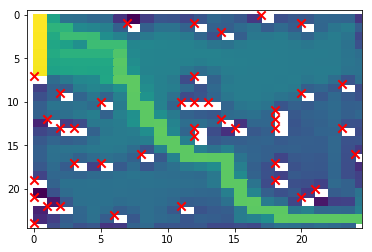

In [422]:
# plot how often a given site was visited
y = np.zeros((game.n, game.m))
for key, val in c.iteritems():
    y[key] = val
plt.pcolor(np.log(y)) # need to flip y-axis to match above

for x, y in game.holes:
    plt.gca().scatter([y], [x], lw=2, c='r', marker='x', s=70)

plt.xlim(-0.5, game.n - 0.5)
plt.ylim(game.m - 0.5, -0.5)

In [423]:
path, _ = game.play()
path
print map_path(game, path)

|v                X       |
|v      X    X       X    |
|v             X          |
|v                        |
|v>>>>>v                  |
|      v                  |
|      v                  |
|X     >v    X            |
|       v               X |
|  X    v            X    |
|     X >vv XXX           |
|         v        X      |
| X       v    X   X      |
|  XX     v  X  X  X    X |
|         >v X            |
|          >v             |
|        X  >>>v         X|
|   X X        v   X      |
|              v          |
|X             >v  X      |
|               v     X   |
|X              >v   X    |
| XX        X    >>v      |
|      X           >>>>>>v|
|X                       G|


(24.5, -0.5)

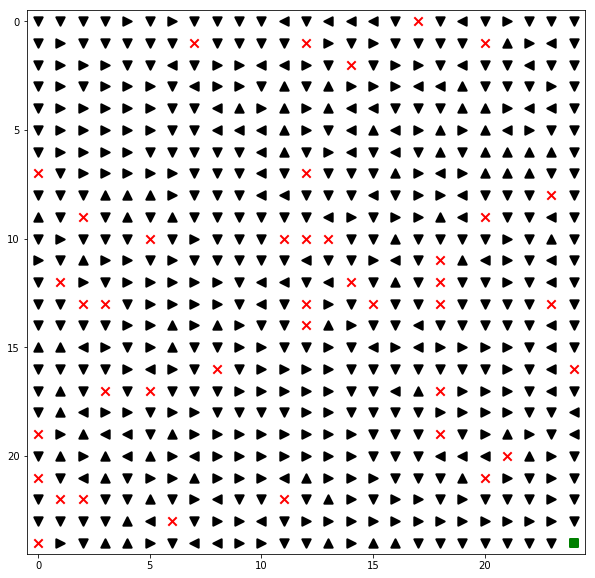

In [424]:
#
# visualize learned strategy
#
actions = ['v', '^', '>', '<']
moves = game.Q.argmax(axis=2)
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
#axes[0,0].pcolor(moves == 0) # down
#axes[0,1].pcolor(moves == 1) # up
#axes[1,0].pcolor(moves == 2) # left
#axes[1,1].pcolor(moves == 3) # right

for x in range(game.n):
    for y in range(game.m):
        if (x,y) in game.holes:
            marker = 'x'
            c = 'r'
        elif (x,y) == game.goal:
            marker = ','
            c = 'g'
        else:
            marker = actions[moves[x,y]]
            c = 'k'

        ax.scatter([y], [x], lw=2, c=c, marker=marker, s=70)        

plt.xlim(-0.5, game.n - 0.5)
plt.ylim(game.m - 0.5, -0.5)